In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae
from utils.metrics import log_rank, cox_estimation, fit_cox_model


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
n_features_bytype = 6
n_active_features = 3 
treatment_effect = 0.5
surv_type = "surv_weibull"
feature_types_list = ['real','cat']
treat_effect_list = np.arange(0., 1.1, 0.2)
coef_init_univ = true_univ_coef(treat_effect_list, 
                                     n_features_bytype = n_features_bytype,
                                     n_active_features = n_active_features,
                                     feature_types_list = feature_types_list, 
                                     surv_type = surv_type,
                                     shape_T = 2, shape_C = 2, scale_C = 6., scale_C_indep = 4.5)

In [3]:
coef_init_univ

array([-0.00102886,  0.11059371,  0.22651491,  0.34644741,  0.44099892,
        0.55165672])

## Compute expected power / level via Schoenfeld formula

$$D = \frac{(\Phi^{-1}(\beta)+\Phi^{-1}(1-\alpha))^2}{P_{cont}(1 - P_{cont}) log^2(\Delta)}$$
where 
- $D$ is the number of deaths
- $\alpha$ is the level
- $\beta$ is the power
- $P_{cont}$ is the proportion of patients in the control arm
- $\Delta$ is the hazard ratio

D

## Replication

In [4]:
n_generated_dataset = 50
dataset_name = "Simulations"

## Independent

In [5]:
M = 500

n_samples = 600
n_features_bytype = 5
n_active_features = 3 
treatment_effect = 0.5
surv_type = "surv_weibull"
feature_types_list = ['real','cat']
log_p_value = []
log_p_value_gen = []
simu_num = []
treat_coef = []
p_treat = []
D_control = []
D_treated = []
treat_effect_list = np.arange(0., 1.1, 0.2)

for treat_effect in treat_effect_list:
    print(treat_effect)
    for m in np.arange(M):
        #if m % 10 == 0:
        #    print(m)
        seed = int(np.random.randint(1000,size = 1))
        control, treated, types = simulation(treat_effect, n_samples,
                                     n_features_bytype = n_features_bytype,
                                     n_active_features = n_active_features,
                                     feature_types_list = feature_types_list, 
                                     surv_type = surv_type,
                                     shape_T = 2, shape_C = 2, scale_C = 6., scale_C_indep = 4.5,seed=seed)
        
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        D_control.append(control['censor'].sum())
        D_treated.append(treated['censor'].sum()) 
        
        p_value_init = compute_logrank_test(control, treated)
    
        log_p_value.append(p_value_init)
        simu_num.append(m)
        treat_coef.append(treat_effect)
        p_treat.append(treated.shape[0]/ (treated.shape[0]+control.shape[0]) )

0.0
0.2
0.4
0.6000000000000001
0.8
1.0


In [6]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "treat_coef" : treat_coef, 'D_control' : D_control,
                         'D_treated' : D_treated})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)

In [7]:
results.head()

,XP_num,log_pvalue_init,treat_coef,D_control,D_treated,reject_H0_init
0,0,0.023239,0.0,265,269,False
1,1,0.152106,0.0,252,287,False
2,2,0.996542,0.0,272,261,False
3,3,1.080469,0.0,257,273,False
4,4,0.172951,0.0,283,250,False


In [13]:
alpha = 0.05
expected_power = []
for j in np.arange(treat_effect_list.shape[0]):
    treatment_effect = treat_effect_list[j]
    Dc = results.groupby("treat_coef").mean()["D_control"].to_numpy()[j]
    Dt = results.groupby("treat_coef").mean()["D_treated"].to_numpy()[j]
    #powe = norm.cdf(np.sqrt( D * p_treated * (1 - p_treated)) * np.abs(treatment_effect) - norm.ppf(1-alpha/2))
    #powe = norm.cdf(np.sqrt( D * p_treated * p_treated * () / (1 + p_treated)) * (1-np.exp( np.abs(treatment_effect)) - norm.ppf(1-alpha/2))

    powe = cpower(Dc , Dt , coef_init_univ[j] ,alpha)
    expected_power.append(powe)
        #norm.cdf(np.sqrt( D * p_treated * (1 - p_treated)) * np.abs(treatment_effect)  - norm.ppf(1 - alpha)))

In [14]:
results[results["reject_H0_init"] ==  False].groupby(["treat_coef"]).mean()

,XP_num,log_pvalue_init,D_control,D_treated,reject_H0_init
treat_coef,,,,,
0.0,249.983968,1.117012,268.593186,259.094188,0.0
0.2,249.580838,0.835543,268.634731,264.395210,0.0
0.4,249.424870,1.950291,267.854922,269.642487,0.0
0.6,245.000000,2.669399,284.000000,268.000000,0.0


Text(0, 0.5, 'Level/power')

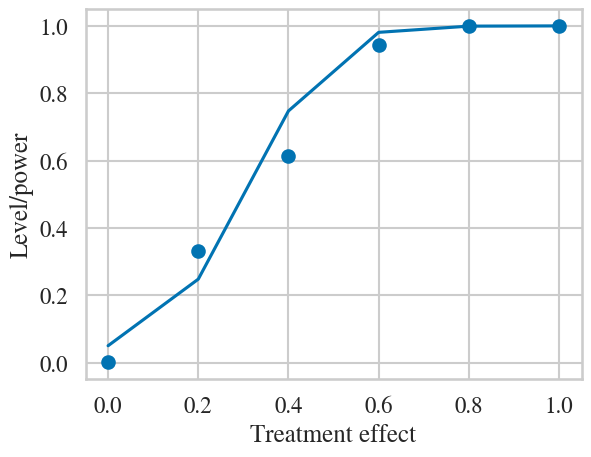

In [15]:
puiss_init = results.groupby("treat_coef").mean()["reject_H0_init"].to_numpy()
plt.scatter(treat_effect_list,puiss_init,label = "All init.")
plt.plot(treat_effect_list,expected_power,label = "Expected level/power")
plt.xlabel("Treatment effect")
plt.ylabel("Level/power")